# Running multiple regression models for the RuBisCO combined dataset

### Following the SeekRank algorithm

In [1]:
import torch
import esm

import random
from collections import Counter
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDRegressor

In [2]:
#Break the array into batches

def batch(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]

## Preparing the data

In [3]:
concat_all_exp_data = pd.read_pickle('/home/kaustubh/RuBisCO_ML/ESM_LoRA/data/processed_combined_all_exp_assays_data.pkl')
concat_all_exp_data = concat_all_exp_data[concat_all_exp_data['LSU_id'] != "SUMO"]
concat_all_exp_data = concat_all_exp_data[concat_all_exp_data['LSU_id'] != "DEAD"]

In [13]:
only_large_assay = concat_all_exp_data[~concat_all_exp_data['LSU_id'].str.startswith("Anc")]
only_large_assay['log_exp_val'] = only_large_assay.apply(lambda x: np.log10(x['Norm_2']) if x['Norm_2'] > 0 else np.nan, axis=1)

/tmp/ipykernel_525449/1805989503.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_large_assay['log_exp_val'] = only_large_assay.apply(lambda x: np.log10(x['Norm_2']) if x['Norm_2'] > 0 else np.nan, axis=1)


(array([45., 17.,  5.,  4.,  3.,  5.,  5.,  2.,  2.,  2.,  1.,  0.,  3.,
         5.,  6.,  1.,  4.,  6.,  1.,  6.,  7.,  2.,  4.,  5.,  4.,  7.,
         4.,  3.,  5.,  4.,  6.,  4.,  5.,  3.,  2.,  0.,  2.,  2.,  2.,
         2.,  3.,  1.,  1.,  1.,  0.,  2.,  0.,  0.,  0.,  2.]),
 array([  4.   ,  13.615,  23.23 ,  32.845,  42.46 ,  52.075,  61.69 ,
         71.305,  80.92 ,  90.535, 100.15 , 109.765, 119.38 , 128.995,
        138.61 , 148.225, 157.84 , 167.455, 177.07 , 186.685, 196.3  ,
        205.915, 215.53 , 225.145, 234.76 , 244.375, 253.99 , 263.605,
        273.22 , 282.835, 292.45 , 302.065, 311.68 , 321.295, 330.91 ,
        340.525, 350.14 , 359.755, 369.37 , 378.985, 388.6  , 398.215,
        407.83 , 417.445, 427.06 , 436.675, 446.29 , 455.905, 465.52 ,
        475.135, 484.75 ]),
 <BarContainer object of 50 artists>)

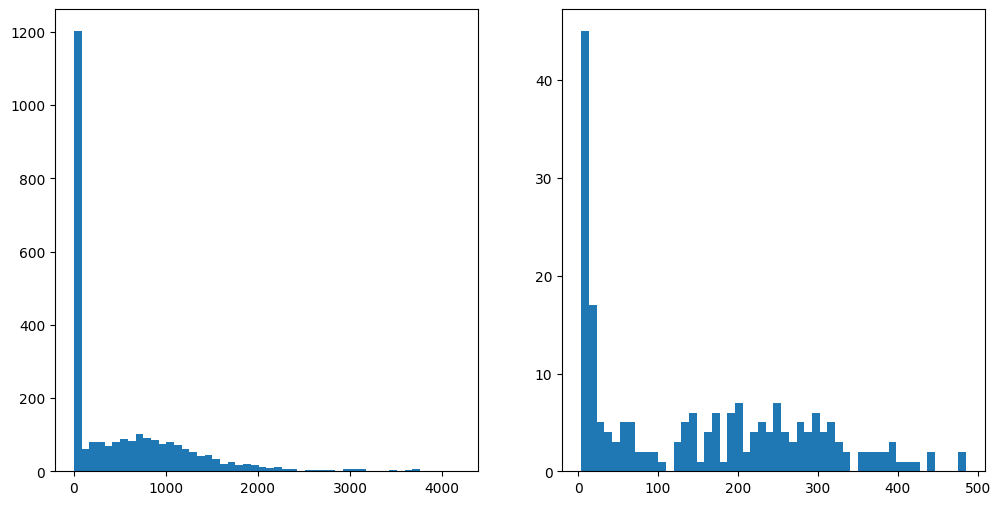

In [4]:
#A side-by-side histogram of "Norm_2" & "mean_reading" column ignoring the NaN values

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(concat_all_exp_data['Norm_2'].dropna(), bins=50)
plt.subplot(1, 2, 2)
plt.hist(concat_all_exp_data['mean_reading'].dropna(), bins=50)

### Really need to normalize the data over these two types of experiments!!!

In [5]:
# For normalization, only considering the highest activity variant "LSU_509 -- SSU_510" pair to calculate the normalization factor for all mutant experiment data

Anc509_normalization_factor = concat_all_exp_data.query('LSU_id == "509" and SSU_id == "510"')['Norm_2'].values[0]/concat_all_exp_data.query('LSU_id == "Anc509"')['mean_reading'].values[0]
Anc509_normalization_factor

np.float64(7.041225669168344)

(array([1.243e+03, 8.100e+01, 8.600e+01, 8.500e+01, 7.400e+01, 8.500e+01,
        8.900e+01, 8.700e+01, 1.020e+02, 9.100e+01, 8.800e+01, 8.100e+01,
        8.600e+01, 7.700e+01, 6.800e+01, 5.500e+01, 5.000e+01, 4.900e+01,
        3.900e+01, 2.400e+01, 2.900e+01, 2.600e+01, 2.400e+01, 2.300e+01,
        1.900e+01, 1.400e+01, 1.800e+01, 1.000e+01, 6.000e+00, 4.000e+00,
        5.000e+00, 7.000e+00, 5.000e+00, 6.000e+00, 4.000e+00, 7.000e+00,
        8.000e+00, 5.000e+00, 1.000e+00, 0.000e+00, 3.000e+00, 4.000e+00,
        2.000e+00, 3.000e+00, 5.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 2.000e+00]),
 array([1.93200972e+00, 8.54359259e+01, 1.68939842e+02, 2.52443758e+02,
        3.35947675e+02, 4.19451591e+02, 5.02955507e+02, 5.86459423e+02,
        6.69963339e+02, 7.53467256e+02, 8.36971172e+02, 9.20475088e+02,
        1.00397900e+03, 1.08748292e+03, 1.17098684e+03, 1.25449075e+03,
        1.33799467e+03, 1.42149859e+03, 1.50500250e+03, 1.58850642e+03,
        1.672010

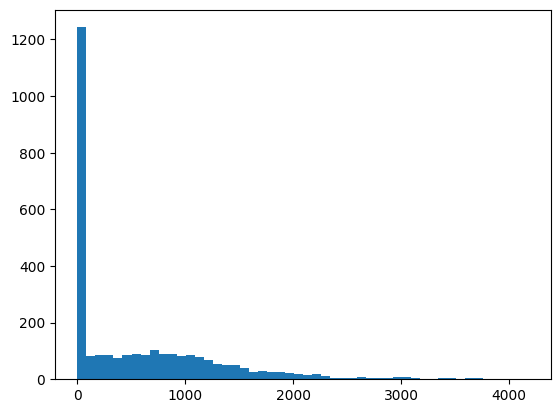

In [12]:
concat_all_exp_data["exp_val"] = concat_all_exp_data.apply(lambda x: x['mean_reading']*Anc509_normalization_factor if x['LSU_id'].startswith("Anc") else x['Norm_2'], axis=1)
plt.hist(concat_all_exp_data['exp_val'].dropna(), bins=50)

(array([  2.,   5.,   4.,  11.,  16.,  10.,  24.,  25.,  27.,  31.,  21.,
         32.,  43.,  61.,  92., 144., 131., 134., 128., 101.,  71.,  56.,
         35.,  26.,  17.,  19.,  17.,  19.,  21.,  32.,  28.,  45.,  41.,
         49.,  47.,  65.,  90., 103., 125., 141., 150., 162., 130., 109.,
         87.,  68.,  24.,  30.,  21.,  14.]),
 array([0.28600931, 0.35270668, 0.41940405, 0.48610141, 0.55279878,
        0.61949615, 0.68619352, 0.75289089, 0.81958826, 0.88628563,
        0.952983  , 1.01968037, 1.08637774, 1.15307511, 1.21977248,
        1.28646984, 1.35316721, 1.41986458, 1.48656195, 1.55325932,
        1.61995669, 1.68665406, 1.75335143, 1.8200488 , 1.88674617,
        1.95344354, 2.02014091, 2.08683827, 2.15353564, 2.22023301,
        2.28693038, 2.35362775, 2.42032512, 2.48702249, 2.55371986,
        2.62041723, 2.6871146 , 2.75381197, 2.82050934, 2.8872067 ,
        2.95390407, 3.02060144, 3.08729881, 3.15399618, 3.22069355,
        3.28739092, 3.35408829, 3.42078566, 3.

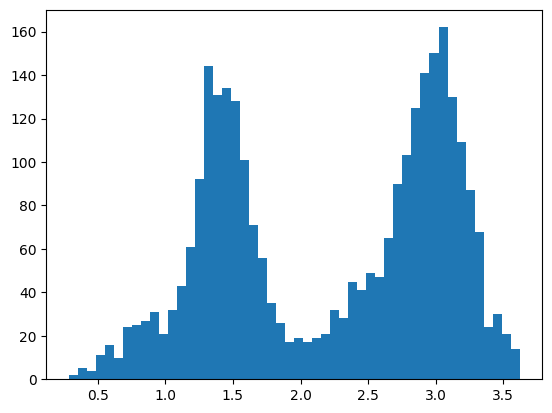

In [13]:
concat_all_exp_data['log_exp_val'] = concat_all_exp_data.apply(lambda x: np.log10(x['exp_val']) if x['exp_val'] > 0 else np.nan, axis=1)
plt.hist(concat_all_exp_data['log_exp_val'].dropna(), bins=50)

### The data is "ready" -- kinda
## Preparing the data for training

In [15]:
Xs = []
ys = []
data = []
headers = []

for i, row in only_large_assay.iterrows():
    header = row['LSUSSU_id']
    headers.append(header)
    sequence = row['lsussu_seq']
    data.append((header, sequence))
    ys.append(row['log_exp_val'])

## Building embeddings

In [ ]:
# Definition for getting the esm model
pretrained_arg = esm.pretrained.esm2_t33_650M_UR50D() ## For ESM-1b: `esm1_t34_670M_UR50S`; ESM-2: `esm2_t33_650M_UR50D()`
layers = 33 ## For ESM-1b: 34; ESM-2: 33
def get_esm_model(pretrained_arg):
    model, alphabet = pretrained_arg
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    model = model.to(device)

    batch_converter = alphabet.get_batch_converter()
    return model, alphabet, batch_converter, device

model, alphabet, batch_converter, device = get_esm_model(pretrained_arg)

sequence_emmbeddings = []
for batch_seqs in batch(data, 10):
    batch_labels, batch_strs, batch_tokens = batch_converter(batch_seqs)

    # Extract per-residue embeddings (on GPU)
    batch_tokens_cuda = batch_tokens.to(device, non_blocking=True)
    with torch.no_grad():
        results = model(batch_tokens_cuda, repr_layers=[layers])
    token_embeddings = results["representations"][layers]

    for i, (_, seq) in enumerate(batch_seqs):
        sequence_emmbeddings.append(token_embeddings[i, 1:len(seq) + 1].mean(0))

## Creating Training and Test set

In [ ]:
Xs = [i.cpu().data.numpy() for i in sequence_emmbeddings]

def generate_train_test(Xs, ys, headers, random_seed, fraction=0.8):
    lsu_list = [x.split("-")[0] for x in headers]
    lsu_list_uniq = pd.Series(lsu_list).unique().copy()
    random.seed(random_seed)
    random.shuffle(lsu_list_uniq)
    train_size = int(len(lsu_list_uniq) * fraction)
    train_set = lsu_list_uniq[:train_size]
    test_set = lsu_list_uniq[train_size:]
    train_indices = [i for i, x in enumerate(lsu_list) if x in train_set]
    test_indices = [i for i, x in enumerate(lsu_list) if x in test_set]

    Xs_train = [Xs[i] for i in train_indices]
    Xs_test = [Xs[i] for i in test_indices]
    ys_train = [ys[i] for i in train_indices]
    ys_test = [ys[i] for i in test_indices]
    return train_set, test_set, Xs_train, Xs_test, ys_train, ys_test

train_ids, test_ids, Xs_train, Xs_test, ys_train, ys_test = generate_train_test(Xs, ys, headers, 42)

In [ ]:
train_ids

array(['412', 'Anc367_mutant_16', 'Anc510_mutant_cluster_26', 'Anc366',
       'Anc367_mutant_48', '369', 'Anc393_mutant_6', '395',
       'Anc510_mutant_cluster_76', '501', 'E7', 'Anc393_mutant_43',
       'Anc393_mutant_30', 'Anc510_mutant_cluster_69', '574',
       'Anc510_mutant_cluster_48', 'Anc510_mutant_cluster_2',
       'Anc510_mutant_cluster_37', 'Anc510_mutant_cluster_71',
       'Anc510_mutant_cluster_40', 'Anc510_mutant_cluster_32',
       'Anc393_mutant_14', 'Anc367_mutant_0', 'Anc510_mutant_cluster_17',
       'Anc510_mutant_cluster_67', 'Anc510_mutant_cluster_36',
       'Anc510_mutant_cluster_62', 'Anc367_mutant_30', '331',
       'Anc367_mutant_41', 'Anc510_mutant_cluster_28', '576',
       'Anc367_mutant_17', 'Anc367_mutant_45', '466', 'Anc367_mutant_1',
       'E2', '374', 'Anc367_mutant_40', '517', 'Anc510_mutant_cluster_82',
       'Anc393', 'Anc367_mutant_32', 'Anc510_mutant_cluster_87',
       'Anc510_mutant_cluster_74', 'Anc510_mutant_cluster_31', '650',
      

In [ ]:
test_ids

array(['509', 'Anc367_mutant_33', 'Anc393_mutant_11',
       'Anc510_mutant_cluster_68', 'Anc510_mutant_cluster_77',
       'Anc367_mutant_47', 'Anc367_mutant_49', 'Anc510_mutant_cluster_52',
       '387', 'Anc367_mutant_25', '453', 'Anc393_mutant_15', 'Anc509',
       '603', 'Anc367_mutant_21', 'Anc393_mutant_47',
       'Anc510_mutant_cluster_7', '397', 'Anc510_mutant_cluster_44',
       '588', 'Anc367_mutant_43', 'Anc367_mutant_42',
       'Anc510_mutant_cluster_54', 'Anc393_mutant_4', '483',
       'Anc393_mutant_16', '477', 'Anc510_mutant_cluster_90',
       'Anc393_mutant_20', 'Anc393_mutant_35', 'Anc367_mutant_7',
       'Anc510_mutant_cluster_57', 'Anc393_mutant_24',
       'Anc510_mutant_cluster_86', 'Anc367_mutant_15', '361',
       'Anc367_mutant_27', 'Anc510_mutant_cluster_83', 'Anc393_mutant_38',
       'Anc510_mutant_cluster_59', 'Anc393_mutant_22', '332',
       'Anc510_mutant_cluster_41', 'Anc365', 'Anc393_mutant_36', '338',
       '405', '336', 'Anc510_mutant_cluster_6

## Training block

In [ ]:
knn_grid = {
    'n_neighbors': [5, 10],
    'weights': ['uniform', 'distance'],
    'algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'leaf_size' : [15, 30],
    'p' : [1, 2],
}

svm_grid = {
    'C' : [0.1, 1.0, 10.0],
    'kernel' :['linear', 'poly', 'rbf', 'sigmoid'],
    'degree' : [3],
    'gamma': ['scale'],
}

rfr_grid = {
    'n_estimators' : [100],
    'criterion' : ['squared_error', 'absolute_error'],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split' : [2, 10],
    'min_samples_leaf': [1, 4]
}
lgr_grid = {

}

In [ ]:
cls_list = [KNeighborsRegressor, SVR, RandomForestRegressor]
param_grid_list = [knn_grid, svm_grid, rfr_grid]
result_list = []
grid_list = []
for cls_name, param_grid in zip(cls_list, param_grid_list):
    print(cls_name)
    grid = GridSearchCV(
        estimator = cls_name(),
        param_grid = param_grid,
        scoring = 'r2',
        verbose = 1,
        n_jobs = -1 # use all available cores
    )
    grid.fit(Xs_train, ys_train)
    result_list.append(pd.DataFrame.from_dict(grid.cv_results_))
    grid_list.append(grid)

<class 'sklearn.neighbors._regression.KNeighborsRegressor'>
Fitting 5 folds for each of 48 candidates, totalling 240 fits


<class 'sklearn.svm._classes.SVR'>
Fitting 5 folds for each of 12 candidates, totalling 60 fits
<class 'sklearn.ensemble._forest.RandomForestRegressor'>
Fitting 5 folds for each of 16 candidates, totalling 80 fits


In [ ]:
grid_list

[GridSearchCV(estimator=KNeighborsRegressor(), n_jobs=-1,
              param_grid={'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                          'leaf_size': [15, 30], 'n_neighbors': [5, 10],
                          'p': [1, 2], 'weights': ['uniform', 'distance']},
              scoring='r2', verbose=1),
 GridSearchCV(estimator=SVR(), n_jobs=-1,
              param_grid={'C': [0.1, 1.0, 10.0], 'degree': [3],
                          'gamma': ['scale'],
                          'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
              scoring='r2', verbose=1),
 GridSearchCV(estimator=RandomForestRegressor(), n_jobs=-1,
              param_grid={'criterion': ['squared_error', 'absolute_error'],
                          'max_features': ['sqrt', 'log2'],
                          'min_samples_leaf': [1, 4],
                          'min_samples_split': [2, 10], 'n_estimators': [100]},
              scoring='r2', verbose=1)]

## Testing the trained model 

KNeighborsRegressor(algorithm='ball_tree', p=1, weights='distance')

Data saved to grid_element_0_activity_data.csv
SVR(C=0.1, kernel='linear')

Data saved to grid_element_1_activity_data.csv
RandomForestRegressor(max_features='sqrt')

Data saved to grid_element_2_activity_data.csv


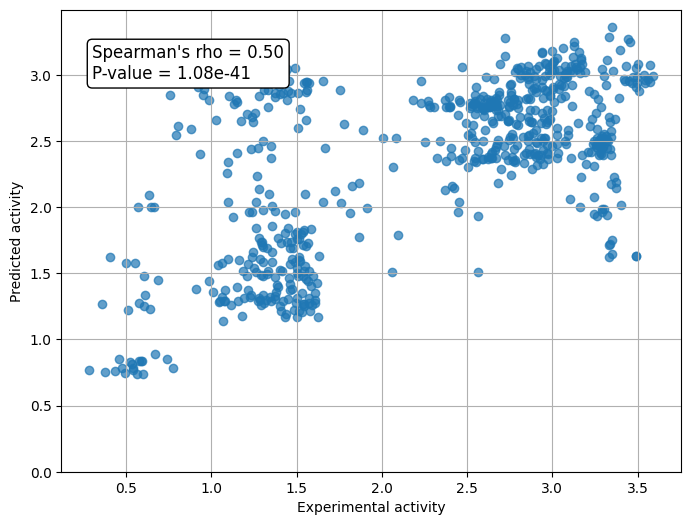

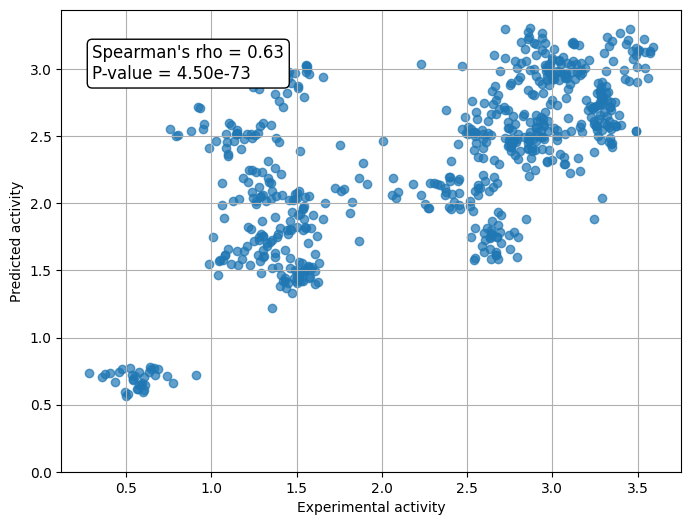

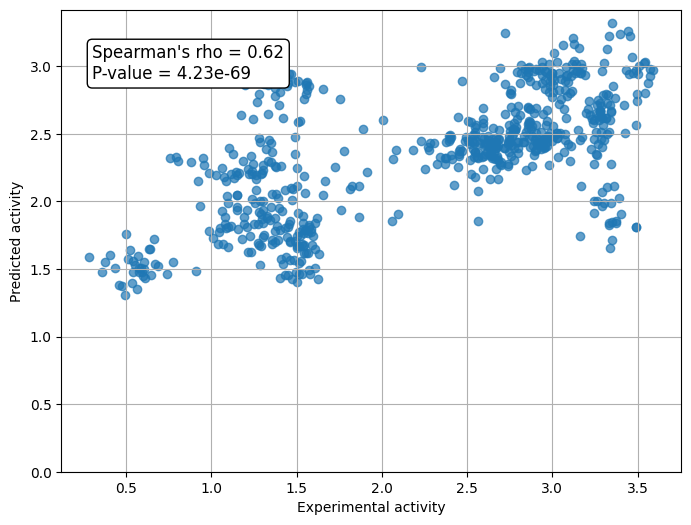

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats

# Assuming grid_list, Xs_test, and ys_test are already defined

for i, grid in enumerate(grid_list):
    print(grid.best_estimator_)
    print()

    # Predictions
    preds = grid.predict(Xs_test)

    # Calculate Spearman's correlation
    rho, p_value = scipy.stats.spearmanr(ys_test, preds)

    # Create a DataFrame and save to CSV
    df = pd.DataFrame({'Experimental Activity': ys_test, 'Predicted Activity': preds})
    csv_filename = f'grid_element_{i}_activity_data.csv'
    df.to_csv(csv_filename, index=False)
    print(f'Data saved to {csv_filename}')

    plt.figure(figsize=(8, 6))
    plt.scatter(ys_test, preds, alpha=0.7)
    plt.ylim(0,)
    plt.xlabel('Experimental activity')
    plt.ylabel('Predicted activity')
    plt.grid(True)

    plt.annotate(f'Spearman\'s rho = {rho:.2f}\nP-value = {p_value:.2e}',
                 xy=(0.05, 0.85), xycoords='axes fraction',
                 fontsize=12, bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'))
